## NOTEBOOK: Create and Evaluate Models

Import libraries

In [155]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     cross_validate, StratifiedKFold, 
                                     cross_val_score)
from sklearn.metrics import (accuracy_score, recall_score, confusion_matrix,
                             roc_curve, auc, make_scorer)

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline

import warnings
warnings.simplefilter('ignore')

Import pickled data

In [3]:
with open('../data/pickled/cleanedData.pkl', 'rb') as fin:
    df = pickle.load(fin)

### Splitting TRAIN-TEST Sets (w/ stratification)

In [5]:
# Define features and target 
data = df.iloc[:,:-1]
labels = df.iloc[:,-1]

In [6]:
X_train, X_test, y_train,y_test =train_test_split(data, labels, 
                                                  test_size=0.20,
                                                 stratify=labels)

In [7]:
# Check that stratification works
print(len(y_train[y_train==1])*100 / len(y_train[y_train==0]))
print(len(y_test[y_test==1])*100 / len(y_test[y_test==0]))

37.517520635415046
37.484433374844336


### Get a 'baseline' Logistic Regresion and Random Forest models with 10-fold CV
Use Pipeline to:
- Oversample 
- Scaling (for Logistic Reg)
- Instantiate classifiers

In [106]:
# Use stratified Kfold
skf = StratifiedKFold(n_splits=10, random_state=7)

In [124]:
pipe_lr = imbPipeline([
    ('oversample', RandomOverSampler(random_state=0)),
    ('scaling', StandardScaler()),
    ('logreg', LogisticRegression())
    ])

eval_lr = cross_validate(pipe_lr, X_train, y_train, 
                         cv=skf, 
                         scoring=('accuracy','recall'),
                         verbose=1,
                         return_train_score=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [146]:
pipe_rf = imbPipeline([
    ('oversample', RandomOverSampler(random_state=0)),
    ('RandomForest', RandomForestClassifier())
    ])
eval_rf = cross_validate(pipe_rf, X_train, y_train, 
                         cv=skf, 
                         scoring=('accuracy','recall'),
                         verbose=1,
                         return_train_score=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [147]:
# Collect CV results into a dataframe
df_lr = pd.DataFrame(np.c_[['LogisticRegression' for _ in range(10)],
                          np.arange(1, 11), 
                          eval_lr['test_accuracy'],
                          eval_lr['test_recall']
                         ], 
                   columns = ['model','fold_id','accuracy','recall'])
df_rf = pd.DataFrame(np.c_[['RandomForest' for _ in range(10)],
                          np.arange(1, 11), 
                          eval_rf['test_accuracy'],
                          eval_rf['test_recall']
                         ], 
                   columns = ['model','fold_id','accuracy','recall'])
df_both = pd.concat([df_lr, df_rf], axis=0)
df_both['accuracy'] = df_both['accuracy'].astype(float)
df_both['recall'] = df_both['recall'].astype(float)

In [148]:
# Checkout the result
df_both.groupby('model')[['accuracy','recall']].mean().sort_values(by='recall',ascending=False)

,accuracy,recall
model,,
LogisticRegression,0.638052,0.660455
RandomForest,0.642808,0.398501


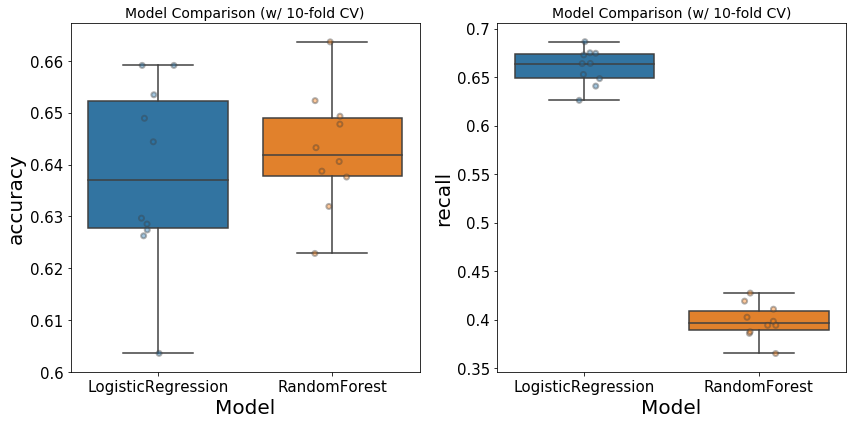

In [300]:
# Plot Accuracy and Recall
scores = ['accuracy','recall']
fig, axes = plt.subplots(1,2,figsize=(12,6))

for i in range(2):
    sns.boxplot(x = 'model', y= scores[i], data=df_both, ax=axes[i] )
    sns.stripplot(x= 'model', y= scores[i], data=df_both,
                    jitter=True, edgecolor="gray", alpha = 0.4,linewidth=2,
                           ax=axes[i])
    axes[i].axes.set_title("Model Comparison (w/ 10-fold CV)",fontsize=14)
    axes[i].set_xlabel("Model",fontsize=20)
    axes[i].set_ylabel(scores[i],fontsize=20)
    axes[i].tick_params(labelsize=15)
    vals = axes[i].get_yticks()
    axes[i].set_yticklabels(['{:,.2}'.format(x) for x in vals])
    plt.tight_layout()
fig.savefig('../docs/figures/baselineModels.png');

- Random Forest performs about the same as Logistic Regression  
- Random Forest has lower variance and slightly higher accuracy (median)
- Logistic Regression has better recall

---

### Grid Searching Hyper-parameters

In [192]:
# Grid-Searching parameters

param_lr   = {'logreg__dual'      : [True, False],
              'logreg__max_iter'  : [100, 150, 300, 500],
              'logreg__C'         : [1.0, 2.0, 3.0, 4.0, 10, 15 ]
            }

param_rf = {'RandomForest__n_estimators'      : [50, 80, 200, 300],
             'RandomForest__max_features'     : ['auto','sqrt','log2'],
             'RandomForest__max_depth'        : [2, 3, 4, 5],
             'RandomForest__min_samples_split': [2, 3, 4],
             'RandomForest__min_samples_leaf' : [1, 2, 4],
             'RandomForest__bootstrap'        : [True, False],
            }

scoring = {'REC': make_scorer(recall_score), 'ACC': make_scorer(accuracy_score)}

In [193]:
# Setup grid search

grid_lr = GridSearchCV(pipe_lr,param_grid=param_lr,
                       return_train_score=True, 
                       n_jobs=-1, scoring=scoring,
                       verbose=1, 
                       refit='REC',
                      cv=skf)
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf,
                       return_train_score=True,
                       refit='REC',
                       verbose=1,
                       n_jobs=-1, scoring=scoring,
                      cv=skf)

In [204]:
# # Run GRID
# grid_lr.fit(X_train, y_train)
# grid_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('oversample', RandomOverSampler(random_state=0, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
          ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'RandomForest__n_estimators': [50, 80, 200, 300], 'RandomForest__max_features': ['auto', 'sqrt', 'log2'], 'RandomForest__max_depth': [2, 3, 4, 5], 'RandomForest__min_samples_split': [2, 3, 4], 'RandomForest__min_samples_leaf': [1, 2, 4], 'RandomForest__bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit='REC', return_train_score=True,
       scoring={

In [230]:
# # Instantiate best Estimator
# Opt_lr = grid_lr.best_estimator_
# Opt_rf = grid_rf.best_estimator_

# # Pickle objects
# with open('../data/gridsearched_lr.pkl','wb') as fin:
#     pickle.dump(Opt_lr, fin)
# with open('../data/gridsearched_rf.pkl','wb') as fin:
#     pickle.dump(Opt_rf, fin)

In [231]:
# UnPickle best estimators objects

with open('../data/pickled/gridsearched_lr.pkl','rb') as fout:
    Opt_lr = pickle.load(fout)
with open('../data/pickled/gridsearched_rf.pkl','rb') as fout:
    Opt_rf = pickle.load(fout)
    
print(Opt_lr, Opt_rf)

Pipeline(memory=None,
     steps=[('oversample', RandomOverSampler(random_state=0, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]) Pipeline(memory=None,
     steps=[('oversample', RandomOverSampler(random_state=0, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [232]:
# Print results of the best_estimators

Opt_models= [grid_lr, grid_rf]
model_names = ['LogReg','RandomForest']
for i in range(2):
    print('Grid Search Result for %s' %(model_names[i]))
    print('best parameters:     ', Opt_models[i].best_params_)
    print('best score     : %.2f' %Opt_models[i].best_score_)
    print('mean accuracy  : %.2f' %Opt_models[i].cv_results_['mean_test_ACC'].mean())
    print('mean recall    : %.2f' %Opt_models[i].cv_results_['mean_test_REC'].mean())
    print()

Grid Search Result for LogReg
best parameters:      {'logreg__C': 10, 'logreg__dual': True, 'logreg__max_iter': 100}
best score     : 0.66
mean accuracy  : 0.64
mean recall    : 0.66

Grid Search Result for RandomForest
best parameters:      {'RandomForest__bootstrap': True, 'RandomForest__max_depth': 2, 'RandomForest__max_features': 'auto', 'RandomForest__min_samples_leaf': 4, 'RandomForest__min_samples_split': 3, 'RandomForest__n_estimators': 80}
best score     : 0.69
mean accuracy  : 0.62
mean recall    : 0.68



### Compare: Grid-Optimized Logistic Regression and Random Forest

In [214]:
pipe_lr_opt = imbPipeline([
    ('oversample', RandomOverSampler(random_state=0)),
    ('scaling', StandardScaler()),
    ('logreg', LogisticRegression(C=10, dual=True, max_iter=100))
    ])

eval_lr_opt = cross_validate(pipe_lr_opt, X_train, y_train, 
                         cv=skf, 
                         scoring=('accuracy','recall'),
                         verbose=1,
                         return_train_score=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [218]:
pipe_rf_opt = imbPipeline([
    ('oversample', RandomOverSampler(random_state=0)),
    ('RandomForest', RandomForestClassifier(bootstrap=True, max_depth=2,
                                           max_features='auto',min_samples_leaf=4,
                                           min_samples_split=3,n_estimators=80))
    ])
eval_rf_opt = cross_validate(pipe_rf_opt, X_train, y_train, 
                         cv=skf, 
                         scoring=('accuracy','recall'),
                         verbose=1,
                         return_train_score=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


In [219]:
# Collect CV results into a dataframe
df_lr_opt = pd.DataFrame(np.c_[['LogisticRegression' for _ in range(10)],
                          np.arange(1, 11), 
                          eval_lr_opt['test_accuracy'],
                          eval_lr_opt['test_recall']
                         ], 
                   columns = ['model','fold_id','accuracy','recall'])
df_rf_opt = pd.DataFrame(np.c_[['RandomForest' for _ in range(10)],
                          np.arange(1, 11), 
                          eval_rf_opt['test_accuracy'],
                          eval_rf_opt['test_recall']
                         ], 
                   columns = ['model','fold_id','accuracy','recall'])
df_both_opt = pd.concat([df_lr_opt, df_rf_opt], axis=0)
df_both_opt['accuracy'] = df_both_opt['accuracy'].astype(float)
df_both_opt['recall'] = df_both_opt['recall'].astype(float)

In [220]:
# Checkout the result
df_both_opt.groupby('model')[['accuracy','recall']].mean().sort_values(by='recall',ascending=False)

,accuracy,recall
model,,
RandomForest,0.619821,0.685349
LogisticRegression,0.637488,0.654213


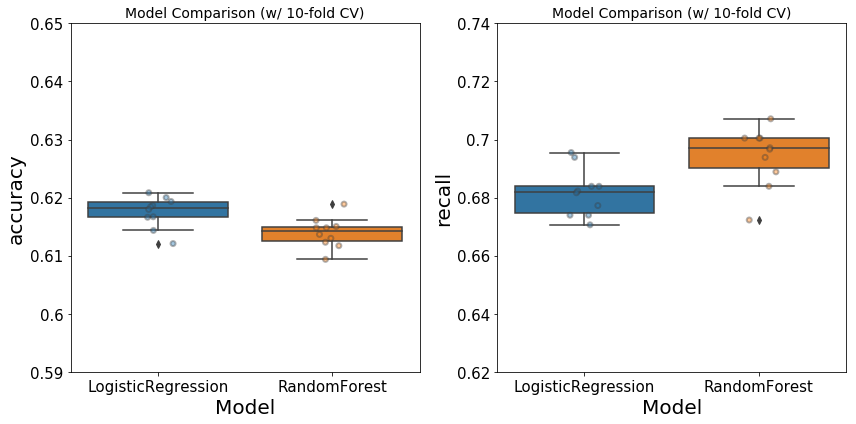

In [297]:
# Plot Accuracy and Recall
scores = ['accuracy','recall']
fig, axes = plt.subplots(1,2,figsize=(12,6))

for i in range(2):
    sns.boxplot(x = 'model', y= scores[i], data=df_both_opt, ax=axes[i] )
    sns.stripplot(x= 'model', y= scores[i], data=df_both_opt,
                    jitter=True, edgecolor="gray", alpha = 0.4,linewidth=2,
                           ax=axes[i])
    axes[i].axes.set_title("Model Comparison (w/ 10-fold CV)",fontsize=14)
    axes[i].set_xlabel("Model",fontsize=20)
    axes[i].set_ylabel(scores[i],fontsize=20)
    axes[i].tick_params(labelsize=15)
    vals = axes[i].get_yticks()
    axes[i].set_yticklabels(['{:,.2}'.format(x) for x in vals])
    axes[i].set_ylim((0.5,0.8))
    plt.tight_layout()
fig.savefig('../docs/figures/GridoptimizedModels.png');

- Logistic Regression has higher accuracy, but 
- Random Forest has higher recall. 
- For this system, **recall** should be more important because we want to make sure that people with obesity is correctly classified

---

---

### Using Optimized-LogReg and RandomForest to predict on the TEST set

#### Plotting ROC curves for both models

In [246]:
# Make pipelines
pipelines = [ 
    ['LogReg', imbPipeline([
                ('oversample', RandomOverSampler(random_state=0)),
                ('scaling', StandardScaler()),
                ('logreg', LogisticRegression(C=10, dual=True, max_iter=100))
                            ])],
    ['RandFor', imbPipeline([
            ('oversample', RandomOverSampler(random_state=0)),
            ('RandomForest', RandomForestClassifier(bootstrap=True, max_depth=2,
                                           max_features='auto',min_samples_leaf=4,
                                           min_samples_split=3,n_estimators=80))
                        ])]
    ]
    

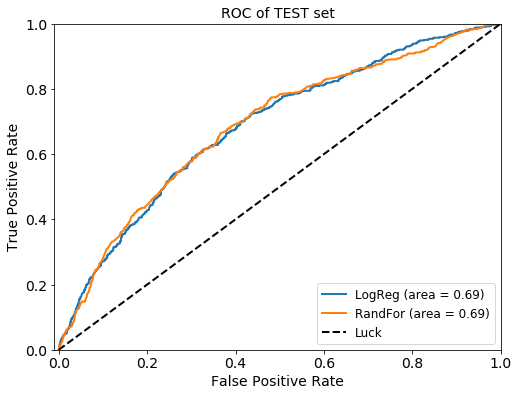

In [307]:
# ROC Curves
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    proba_test = pipeline.predict_proba(X_test)
    predict_test = proba_test[:,1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.plot(fpr_test, tpr_test, linestyle='-',
             label='{} (area = %0.2f)'.format(name) %roc_auc_test, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')

# make nice plotting
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-0.01, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC of TEST set', fontsize=14)

plt.legend(loc="lower right", fontsize=12)

plt.show()
fig.savefig('../docs/figures/ROCcurveTEST.png');

#### Plot Confusion Matrix


For LogReg
Accuracy: 0.65
Recall  : 0.62

For RandFor
Accuracy: 0.63
Recall  : 0.68


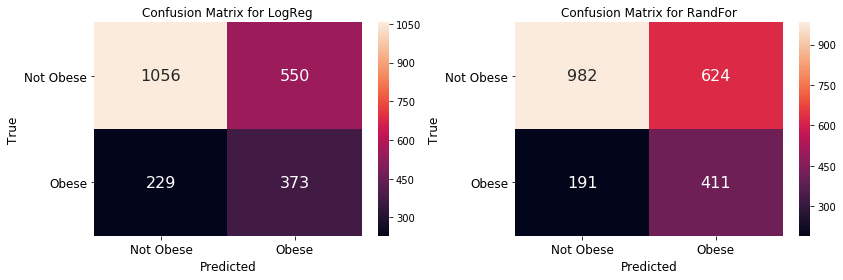

In [309]:
# Confusion Matrix
fig, axes = plt.subplots(1,2,figsize=(12,4))
names=['LogReg','RandomFor']

for ind,(name,pipeline) in enumerate(pipelines):
    pipeline.fit(X_train, y_train)
    y_predicted_test = pipeline.predict(X_test)
    print()
    print(f'For {name}')
    print('Accuracy: %.2f' %accuracy_score(y_test, y_predicted_test))
    print('Recall  : %.2f' %recall_score(y_test, y_predicted_test))
    sns.heatmap(confusion_matrix(y_test, y_predicted_test), 
                annot=True,
                fmt='d', annot_kws={'size':16}, 
                ax=axes[ind])
    axes[ind].set_ylabel('True', fontsize=12)
    axes[ind].set_xlabel('Predicted', fontsize=12)
    axes[ind].set_title(f'Confusion Matrix for {name}')
    axes[ind].set_yticklabels(['Not Obese', 'Obese'], rotation=0, fontsize=12)
    axes[ind].set_xticklabels(['Not Obese', 'Obese'], rotation=0, fontsize=12)    
    plt.tight_layout()
    fig.savefig(f'../docs/figures/ConfusionMat_{names[ind]}.png')
plt.show();


Conclusion:
- Much work is still needed to improve the models, since the accuracy is only ~64%.
- Though the two models perform similarly in terms of accuracy, the **Random Forest** has a slightly **higher recall** 
- The false negative for Random Forest, 191, is lower than that for Logistic Regression, 223. This means 32 people are potentially saved (if this was a disease-diagnosis scenario). So, training the dataset using Random Forest seems reasonable (see Step 4 notebook).

---

---

### Train the entire dataset for deployment

In [289]:
# Train dataset using Random Forest
deployment_model = pipelines[1][1].fit(data, labels)

In [291]:
# Pickle the model
with open('../data/pickled/FinalModel.pkl','wb') as fout:
    pickle.dump(deployment_model, fout)

---

---